# Job Classifier

The goal of this notepad is to create simple classifier which shold map occupations to some group.
The classifier is based on [O*net Online groups](https://www.onetonline.org/find/family?f=0&g=Go)
It is assumed to use the obtained classifier to work with the column "work" of the [ForeverAlone Dataset](https://www.kaggle.com/kingburrito666/the-demographic-rforeveralone-dataset).

#### The dataset columns:
+ Code - O*NET-SOC Code. It's not important for this research
+ Occupation - job title
+ Job Family - groups of occupations based upon work performed, skills, education, training, and credentials.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
occupations_ds = pd.read_csv('All_Occupations.csv')

In [3]:
occupations_ds.head()

,Code,Occupation,Job Family
0,13-2011.01,Accountants,Business and Financial Operations
1,13-2011.00,Accountants and Auditors,Business and Financial Operations
2,27-2011.00,Actors,"Arts, Design, Entertainment, Sports, and Media"
3,15-2011.00,Actuaries,Computer and Mathematical
4,29-1199.01,Acupuncturists,Healthcare Practitioners and Technical


In [4]:
# We don't need job code for this classifier.
occupations_ds = occupations_ds.drop('Code', axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11c8164d0>]],
      dtype=object)

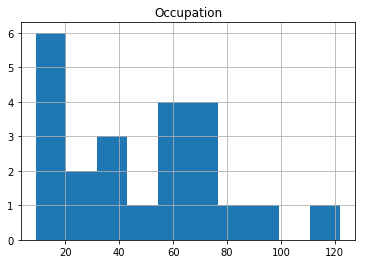

In [5]:
occupations_ds.groupby('Job Family').count().hist()

The dataset isn't balanced. Class weight to deal with it.

Also, and more important, there is no class "Not a job". There are lot of trash in job_title column of ForeverAlone dataset (like "what?", "u serious?" etc).
It's a natural language and it's good idea to use tweets to define it. Lets add some tweets with labels "None" to our dataset.

The tweets corpus was taken from [Sentiment140 dataset](https://www.kaggle.com/kazanova/sentiment140).
Unfortunately, I can't share the dataset because of file size limit on GitHub. But you can always download it from Kaggle.

In [45]:
not_a_job_list = pd.read_csv('tweets.csv', names=['target', 'ids', 'date', 'flag', 'user', 'Occupation'])
not_a_job_list = not_a_job_list.drop(['target', 'ids', 'date', 'flag', 'user'], axis=1)
not_a_job_list['Job Family'] = 'None'
occupations_ds = pd.concat([occupations_ds, not_a_job_list.sample(n=2000)])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x138c1dc10>]],
      dtype=object)

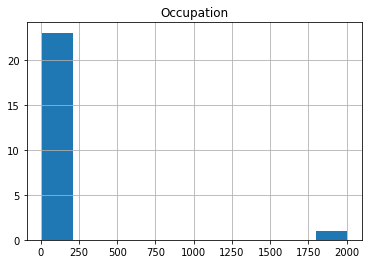

In [7]:
occupations_ds.groupby('Job Family').count().hist()

In [23]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.svm import SVC

[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) seems like a good choice to estimate importance of each single word for each single class. We'll use **TfidfTransformer** and **CountVectorizer** to extract features.

Also I think it's a good idea to remove stop words and convert words to base form to increase classifier performance. **CountVectorizer** has *stop_words* argument and can remove english stop words automatically. In order to convert words to base form we'll use lemmatizer from spacy library.

We need to save our custom vectorizer to file and import it if we want save and load our classifier with **joblib**

In [9]:
%%writefile spacyvectorizer.py
from sklearn.feature_extraction.text import CountVectorizer
import spacy
spacy.load('en')
class SpacyVectorizer(CountVectorizer):
    lemmatizer = spacy.lang.en.English()
    def __init__(self, stop_words, ngram_range, analyzer, max_features=None):
        super(SpacyVectorizer, self).__init__(stop_words = stop_words, ngram_range = ngram_range, \
                                              analyzer = analyzer, max_features = max_features, \
                                              tokenizer = SpacyVectorizer.l_tokenizer)
    @staticmethod
    def l_tokenizer(doc):
        tokens = SpacyVectorizer.lemmatizer(doc)
        return([token.lemma_ for token in tokens if not token.is_punct])

Overwriting spacyvectorizer.py


In [10]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

from forever_alone_kaggle.SpacyVectorizer import SpacyVectorizer

In [26]:
pipeline = Pipeline([
    ('vect', SpacyVectorizer(stop_words='english', ngram_range=(1,1), analyzer='word')),
    ('tfidf', TfidfTransformer()),
    ('clf', SVC(class_weight='balanced')),
])
parameters = {'clf__C':[2**i for i in range(-5, 16, 2)], \
              'clf__gamma':[2**i for i in range(-15, 4, 2)], \
              'vect__max_features':[1200, 2000]}
# Let's use cross-validation algorithm to get better parameters of our model. 
# Scoring is balanced because we have much more tweets than job titles in our dataset
job_classifier = GridSearchCV(pipeline, parameters, cv=5, iid=True, scoring='balanced_accuracy')

In [27]:
job_classifier.fit(occupations_ds['Occupation'], occupations_ds['Job Family'])
job_classifier_best = job_classifier.best_estimator_

In [28]:
all_predictions = job_classifier_best.predict(occupations_ds['Occupation'])
print(classification_report(occupations_ds['Job Family'],all_predictions))

                                                precision    recall  f1-score   support

                  Architecture and Engineering       0.94      0.90      0.92        80
Arts, Design, Entertainment, Sports, and Media       0.82      0.87      0.84        52
 Building and Grounds Cleaning and Maintenance       0.75      0.90      0.82        10
             Business and Financial Operations       0.83      0.86      0.84        57
                  Community and Social Service       0.89      0.94      0.92        18
                     Computer and Mathematical       0.90      0.77      0.83        35
                   Construction and Extraction       0.90      0.81      0.85        67
              Education, Training, and Library       0.98      0.88      0.93        66
                Farming, Fishing, and Forestry       1.00      0.90      0.95        21
          Food Preparation and Serving Related       0.84      0.84      0.84        19
        Healthcare Practitioner

Pretty good f1-score. But it's true for a data which was used to train model. What about new tweets?

In [43]:
pd.Series((job_classifier_best.predict(not_a_job_list['Occupation'].sample(n=10000)) == 'None')).value_counts()

True     9903
False      97
dtype: int64

In [44]:
# I think it's pretty good too. Let's save our classifier for further work.
from joblib import dump
dump(job_classifier_best, 'job_classifier.joblib') 

['job_classifier.joblib']